Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be 
    # fed at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights = tf.Variable(
        tf.truncated_normal((image_size * image_size, num_labels)))
    biases = tf.Variable(tf.zeros((num_labels)))
    
    # Training computation
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Prediction for the training, validation, and test data
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
            beta_regul: 1e-3
        }
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.331808
Minibatch accuracy: 10.2%
Validation accuracy: 14.5%
Minibatch loss at step 500: 2.985050
Minibatch accuracy: 72.7%
Validation accuracy: 76.6%
Minibatch loss at step 1000: 1.984950
Minibatch accuracy: 75.0%
Validation accuracy: 79.3%
Minibatch loss at step 1500: 1.202626
Minibatch accuracy: 82.8%
Validation accuracy: 80.6%
Minibatch loss at step 2000: 1.034912
Minibatch accuracy: 78.9%
Validation accuracy: 81.0%
Minibatch loss at step 2500: 1.100692
Minibatch accuracy: 77.3%
Validation accuracy: 82.0%
Minibatch loss at step 3000: 0.694152
Minibatch accuracy: 82.8%
Validation accuracy: 82.2%
Test accuracy: 87.7%


In [8]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {
          tf_train_dataset: batch_data, 
          tf_train_labels: batch_labels, 
          beta_regul: regul
      }
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

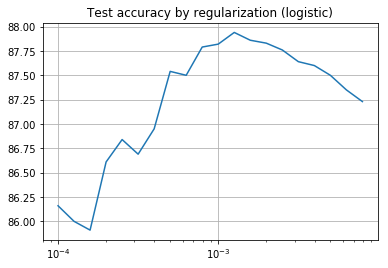

In [9]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

## 1-layer nural network

In [10]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be 
    # fed at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
            beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # predictions
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [11]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
            beta_regul: 1e-3
        }
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 598.693970
Minibatch accuracy: 13.3%
Validation accuracy: 25.6%
Minibatch loss at step 500: 198.247620
Minibatch accuracy: 71.9%
Validation accuracy: 78.3%
Minibatch loss at step 1000: 114.633354
Minibatch accuracy: 78.9%
Validation accuracy: 82.6%
Minibatch loss at step 1500: 68.432053
Minibatch accuracy: 86.7%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 42.262886
Minibatch accuracy: 82.0%
Validation accuracy: 84.9%
Minibatch loss at step 2500: 25.364660
Minibatch accuracy: 81.2%
Validation accuracy: 87.0%
Minibatch loss at step 3000: 15.373071
Minibatch accuracy: 91.4%
Validation accuracy: 87.2%
Test accuracy: 92.8%


In [12]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:    
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

KeyboardInterrupt: 

In [ ]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [14]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [15]:
num_steps = 101
num_bacthes = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_bacthes
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 250.924637
Minibatch accuracy: 18.0%
Validation accuracy: 32.8%
Minibatch loss at step 2: 1056.367065
Minibatch accuracy: 40.6%
Validation accuracy: 41.0%
Minibatch loss at step 4: 276.047852
Minibatch accuracy: 60.9%
Validation accuracy: 55.5%
Minibatch loss at step 6: 3.408622
Minibatch accuracy: 98.4%
Validation accuracy: 61.8%
Minibatch loss at step 8: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.8%
Minibatch loss at step 10: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.8%
Minibatch loss at step 12: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.8%
Minibatch loss at step 14: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.8%
Minibatch loss at step 16: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.8%
Minibatch loss at step 18: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.8%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.8%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [16]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  logits = tf.matmul(drop1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [18]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 436.009705
Minibatch accuracy: 10.2%
Validation accuracy: 35.0%
Minibatch loss at step 2: 1002.978271
Minibatch accuracy: 38.3%
Validation accuracy: 51.9%
Minibatch loss at step 4: 344.597778
Minibatch accuracy: 70.3%
Validation accuracy: 59.6%
Minibatch loss at step 6: 60.410004
Minibatch accuracy: 86.7%
Validation accuracy: 66.6%
Minibatch loss at step 8: 2.479553
Minibatch accuracy: 97.7%
Validation accuracy: 65.7%
Minibatch loss at step 10: 3.948230
Minibatch accuracy: 96.9%
Validation accuracy: 66.7%
Minibatch loss at step 12: 6.087380
Minibatch accuracy: 96.1%
Validation accuracy: 66.9%
Minibatch loss at step 14: 4.628611
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 16: 2.590599
Minibatch accuracy: 98.4%
Validation accuracy: 65.5%
Minibatch loss at step 18: 2.066358
Minibatch accuracy: 99.2%
Validation accuracy: 66.0%
Minibatch loss at step 20: 1.658137
Minibatch accuracy: 98.4%
Validation accuracy: 66.9%
Miniba

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [21]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # variables
    weights1 = tf.Variable(
        tf.truncated_normal(
            [image_size * image_size, num_hidden_nodes1],
            stddev=np.sqrt(2.0 / (image_size * image_size))
        )
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes1, num_hidden_nodes2],
            stddev=np.sqrt(2.0 / (num_hidden_nodes1))
        )
    )
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes2, num_labels],
            stddev=np.sqrt(2.0 / num_hidden_nodes2)
        )
    )
    biases3 = tf.Variable(tf.zeros([num_labels]))
    
    # training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    logits = tf.matmul(lay2_train, weights3) + biases3
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=tf_train_labels) + \
            beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    )
    
    # optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # output
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [24]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
        }
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction],
            feed_dict=feed_dict
        )
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.185713
Minibatch accuracy: 13.3%
Validation accuracy: 31.6%
Minibatch loss at step 500: 1.266649
Minibatch accuracy: 79.7%
Validation accuracy: 85.4%
Minibatch loss at step 1000: 0.874565
Minibatch accuracy: 85.9%
Validation accuracy: 87.7%
Minibatch loss at step 1500: 0.676978
Minibatch accuracy: 88.3%
Validation accuracy: 88.3%
Minibatch loss at step 2000: 0.795551
Minibatch accuracy: 82.8%
Validation accuracy: 88.8%
Minibatch loss at step 2500: 0.662780
Minibatch accuracy: 84.4%
Validation accuracy: 89.2%
Minibatch loss at step 3000: 0.457554
Minibatch accuracy: 92.2%
Validation accuracy: 89.2%
Minibatch loss at step 3500: 0.507621
Minibatch accuracy: 93.0%
Validation accuracy: 89.3%
Minibatch loss at step 4000: 0.623531
Minibatch accuracy: 85.2%
Validation accuracy: 89.8%
Minibatch loss at step 4500: 0.470235
Minibatch accuracy: 92.2%
Validation accuracy: 90.2%
Minibatch loss at step 5000: 0.431158
Minibatch accuracy: 93.0%
Validation accurac

## added one more layer

In [33]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # variables
    weights1 = tf.Variable(
        tf.truncated_normal(
            [image_size * image_size, num_hidden_nodes1],
            stddev=np.sqrt(2.0 / (image_size * image_size))
        )
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes1, num_hidden_nodes2],
            stddev=np.sqrt(2.0 / (num_hidden_nodes1))
        )
    )
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes2, num_hidden_nodes3],
            stddev=np.sqrt(2.0 / num_hidden_nodes2)
        )
    )
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes3, num_labels],
            stddev=np.sqrt(2.0 / num_hidden_nodes3)
        )
    )
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    
    # training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    #drop1 = tf.nn.dropout(lay1_train, 0.5)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    #drop2 = tf.nn.dropout(lay2_train, 0.5)
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
    #drop3 = tf.nn.dropout(lay3_train, 0.5)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=tf_train_labels) + \
            beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    )
    
    # optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # output
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [34]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
        }
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction],
            feed_dict=feed_dict
        )
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.456061
Minibatch accuracy: 9.4%
Validation accuracy: 30.0%
Minibatch loss at step 500: 1.325977
Minibatch accuracy: 81.2%
Validation accuracy: 85.6%
Minibatch loss at step 1000: 0.956573
Minibatch accuracy: 85.9%
Validation accuracy: 87.3%
Minibatch loss at step 1500: 0.754438
Minibatch accuracy: 88.3%
Validation accuracy: 88.5%
Minibatch loss at step 2000: 0.826775
Minibatch accuracy: 82.8%
Validation accuracy: 88.8%
Minibatch loss at step 2500: 0.704565
Minibatch accuracy: 85.9%
Validation accuracy: 89.3%
Minibatch loss at step 3000: 0.453666
Minibatch accuracy: 93.0%
Validation accuracy: 89.4%
Minibatch loss at step 3500: 0.527943
Minibatch accuracy: 92.2%
Validation accuracy: 89.4%
Minibatch loss at step 4000: 0.647261
Minibatch accuracy: 86.7%
Validation accuracy: 89.9%
Minibatch loss at step 4500: 0.459133
Minibatch accuracy: 93.0%
Validation accuracy: 90.4%
Minibatch loss at step 5000: 0.401172
Minibatch accuracy: 93.0%
Validation accuracy

# added dropout

In [35]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    # variables
    weights1 = tf.Variable(
        tf.truncated_normal(
            [image_size * image_size, num_hidden_nodes1],
            stddev=np.sqrt(2.0 / (image_size * image_size))
        )
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes1, num_hidden_nodes2],
            stddev=np.sqrt(2.0 / (num_hidden_nodes1))
        )
    )
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes2, num_hidden_nodes3],
            stddev=np.sqrt(2.0 / num_hidden_nodes2)
        )
    )
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(
        tf.truncated_normal(
            [num_hidden_nodes3, num_labels],
            stddev=np.sqrt(2.0 / num_hidden_nodes3)
        )
    )
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    
    # training computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    drop2 = tf.nn.dropout(lay2_train, 0.5)
    lay3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
    drop3 = tf.nn.dropout(lay3_train, 0.5)
    logits = tf.matmul(drop3, weights4) + biases4
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=tf_train_labels) + \
            beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    )
    
    # optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # output
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [36]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset: (offset + batch_size), :]
        batch_labels = train_labels[offset: (offset + batch_size), :]
        
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
        }
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction],
            feed_dict=feed_dict
        )
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.852682
Minibatch accuracy: 12.5%
Validation accuracy: 18.7%
Minibatch loss at step 500: 1.603865
Minibatch accuracy: 74.2%
Validation accuracy: 84.2%
Minibatch loss at step 1000: 1.194526
Minibatch accuracy: 79.7%
Validation accuracy: 85.7%
Minibatch loss at step 1500: 0.955791
Minibatch accuracy: 84.4%
Validation accuracy: 86.5%
Minibatch loss at step 2000: 0.943270
Minibatch accuracy: 82.0%
Validation accuracy: 86.7%
Minibatch loss at step 2500: 0.896915
Minibatch accuracy: 82.0%
Validation accuracy: 87.5%
Minibatch loss at step 3000: 0.593469
Minibatch accuracy: 90.6%
Validation accuracy: 87.5%
Minibatch loss at step 3500: 0.697932
Minibatch accuracy: 91.4%
Validation accuracy: 88.4%
Minibatch loss at step 4000: 0.731604
Minibatch accuracy: 82.8%
Validation accuracy: 88.5%
Minibatch loss at step 4500: 0.832615
Minibatch accuracy: 82.0%
Validation accuracy: 89.0%
Minibatch loss at step 5000: 0.568346
Minibatch accuracy: 89.8%
Validation accurac